# Dataset Inspection
Here a dataset will be inspected in order to establish whether there are any problems which will need to be addressed before it can be used for data analytics purposes, e.g.:
* Are there any missing values?
* Are the values in the data correctly and consistenly formatted?
* Does any category value feature contain invalid categories? This could be typos for example.

In [1]:
import pandas as pd
import numpy as np

## 1. Read the dataset into a Pandas DataFrame
Pandas DataFrames offer a lot of functionality for inspecting and efficiently manipulating data.

In [2]:
raw_data = "./dataset/interview_signup.csv"
#Note: A converter is necessary when reading in the postcode data in order to ensure 
#      that any leading zeroes are preserved.
df = pd.read_csv(raw_data, converters={'postcode': lambda x: str(x)})

## 2. Inspect the column names
Quick initial check to see that the features we expect are reflected in the DataFrame column names.

In [3]:
print("Columns:",df.columns.values) # Get the values from the Index object 'columns' 
print("Total features:",df.columns.shape[0]) # Get the total number of features: inputs plus target

Columns: ['original_product_name' 'postcode' 'bundesland' 'total_bonus'
 'order_date']
Total features: 5


## 3. A quick look at the data:
First the DataFrame itself...

In [4]:
df

,original_product_name,postcode,bundesland,total_bonus,order_date
0,E.ON STROM,53229,Nordrhein-Westfalen,146.0,2018-01-01
1,E.ON STROM ÖKO,74235.0,Baden-Württemberg,67.0,2018-01-01
2,E.ON STROM ÖKO 24,45257,Nordrhein-Westfalen,123.0,2018-01-01
3,E.ON STROM,64395,Hessen,159.0,2018-01-01
4,E.ON STROM 24,36039,Hessen,116.0,2018-01-01
...,...,...,...,...,...
318340,E.ON STROM 24,49610,Niedersachsen,147.0,2018-12-31
318341,E.ON STROM,4916.0,NaN,142.0,2018-12-31
318342,E.ON STROM,77972.0,Baden-Württemberg,48.0,2018-12-31
318343,E.ON STROM ÖKO 24,91466,Bayern,238.0,2018-12-31


A quick visual inspection of the data shows that some of the postcode data has been recorded as a floating point number, this will have to be addressed during data cleansing.

Now let's get a concise summary of the DataFrame:

* index dtype,
* columns,
* non-null values and 
* memory usage

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_product_name  318345 non-null  object 
 1   postcode               318345 non-null  object 
 2   bundesland             288813 non-null  object 
 3   total_bonus            318345 non-null  float64
 4   order_date             318345 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.1+ MB


Looks as though there are missing values in the **'bundesland'** column. Let's just double-check the null value count with another function:

In [6]:
# Count missing values in the dataset for each feature
df.isnull().sum()

original_product_name        0
postcode                     0
bundesland               29532
total_bonus                  0
order_date                   0
dtype: int64

What proportion of the dataset is affected by missing values?

In [7]:
# Proportion of 'bundesland' feature with missing value
df.isnull().sum()[2] / df.shape[0]

0.09276728078028554

About 10% of the data is affected.

## 4. Inspecting the individual features

* **original_product_name:** Product the customer signed up to
* **postcode:** Postcode of the customer (5 digits with 0-9)
* **bundesland:** The state the customer lives
* **total_bonus:** The bonus amount we provided (reduces the first year price)
* **order_date:** The date that the customer ordered the product

We already know that we have missing values in the **'bundesland'** feature. Let's see if there are any other issues...

### Feature: original_product_name
This is a categorical feature, let's see what categories are present in the feature data.

In [8]:
df['original_product_name'].unique()

array(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24',
       'E.ON STROM 24', 'E.ON STROM PUR', 'E.ON STROM Ã–KO',
       'E.ON STROM 24 24 24', 'E.ON STROM 24 24', 'E.ON STROM ÖO',
       'E.ON STROM 24 24 24 24 24 24 24'], dtype=object)

Looks like there are a few typos! Let's check the incidence of all these categories in the dataset.

E.ON STROM                         164473
E.ON STROM 24                       69363
E.ON STROM ÖKO                      55194
E.ON STROM ÖKO 24                   25440
E.ON STROM PUR                       3650
E.ON STROM Ã–KO                       206
E.ON STROM 24 24                       14
E.ON STROM 24 24 24 24 24 24 24         2
E.ON STROM 24 24 24                     2
E.ON STROM ÖO                           1
Name: original_product_name, dtype: int64

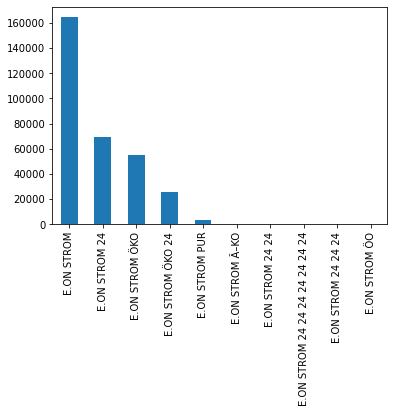

In [9]:
df['original_product_name'].value_counts().plot.bar()
df['original_product_name'].value_counts()

The low incidence of 5 of these tarifs is an indication that they may be invalid data.

A quick look here: https://www.verivox.de/strom/anbieter/eon/ reveals the following tarifs to exist:
* E.ON STROM
* E.ON STROM 24
* E.ON STROM PUR
* E.ON STROM ÖKO
* E.ON STROM ÖKO 24

It can be concluded that the other tarif categories are typos. **Cleansing required!!**

### Feature: postcode
This is a categorical feature, let's see what categories are present in the feature data.

In [10]:
df['postcode'].unique()

array(['53229', '74235.0', '45257', ..., '79424.0', '27246.0', '67473.0'],
      dtype=object)

Not really practical, but once again we can see the issue with some PLZ having been recorded as floating point numbers!

Let's try assessing the validity of the PLZ in the postcode feature by checking that they are 5 digits long and contain only numbers.

Any invalid PLZ data will be extracted for inspection.

**Note:** the information here: https://www.python-forum.de/viewtopic.php?t=41275 was helpful in terms of creating checks on PLZ data.

In [11]:
# import a helper for working with PLZ data
import utility.plz_helper as plz_helper

#Create a mask by applying list comprehension to check the validity of each PLZ in the postcode column
mask = [plz_helper.check_invalid_plz_format(str(x)) for x in df['postcode']]
mask

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False

Now we'll extract the invalid data (not comforming to PLZ format) to a DataFrame and perform a quick visual inspection to see whether we can spot any problems in the data for the postcode feature.

In [12]:
result_df = df[mask]
result_df

,original_product_name,postcode,bundesland,total_bonus,order_date
24,E.ON STROM,4319.0,Sachsen,55.0,2018-01-01
26,E.ON STROM 24,7318.0,NaN,154.0,2018-01-01
32,E.ON STROM,8315.0,Sachsen,144.0,2018-01-01
49,E.ON STROM,6385.0,NaN,156.0,2018-01-01
60,E.ON STROM ÖKO,7407,Thüringen,96.0,2018-01-01
...,...,...,...,...,...
318304,E.ON STROM,7751,Thüringen,162.0,2018-12-31
318309,E.ON STROM,4249,Sachsen,203.0,2018-12-31
318314,E.ON STROM,7973.0,Thüringen,200.0,2018-12-31
318321,E.ON STROM,8393,Sachsen,121.0,2018-12-31


The invalid postcode data appears to have be 4 digits rather than 5 in length.

Could the problem be that leading zeroes are missing? After the reunification of Germany some of the _new states_ received PLZ with a leading 0 (https://en.wikipedia.org/wiki/List_of_postal_codes_in_Germany).

Let's check which states (Bundesland) are affected by this problem.

In [13]:
result_df['bundesland'].unique()

array(['Sachsen', nan, 'Thüringen', 'Sachsen-Anhalt', 'Brandenburg'],
      dtype=object)

This 4 digit PLZ problem only occurs only with new states which have PLZ with a leading 0.

Note: This type of error in the data is typical when a mask has been used for data entry which interprets the PLZ 
as a number (int / float) and therefore ignores the leading zero.  Care was taken at the start of this notebook to ensure that this leading 0 wasn't removed when reading the data into the DataFrame by use of a converter. It can therefore be concluded that the error had already been introduced into the data prior to its use here.

More cleansing needed here: the 4 digit cases will need to have '0' added to start.

### Feature: bundesland
This is a categorical feature, let's see what categories are present in the feature data.

In [14]:
df['bundesland'].unique()

array(['Nordrhein-Westfalen', 'Baden-Württemberg', 'Hessen', 'Berlin',
       'Schleswig-Holstein', 'Niedersachsen', nan, 'Bayern',
       'Rheinland-Pfalz', 'Sachsen', 'Bremen', 'Brandenburg', 'Thüringen',
       'Saarland', 'Mecklenburg-Vorpommern', 'Hamburg', 'Sachsen-Anhalt'],
      dtype=object)

Those look correct. The nan occurs due to missing values for this feature (which we already discovered).

Let's explore this feature a bit more to get a feel for the way in which its values are distributed.

Nordrhein-Westfalen       68541
Bayern                    50741
Baden-Württemberg         35447
Niedersachsen             34885
Hessen                    19898
Rheinland-Pfalz           16348
Schleswig-Holstein        12961
Brandenburg                8799
Sachsen                    8642
Berlin                     8262
Thüringen                  5972
Mecklenburg-Vorpommern     5480
Sachsen-Anhalt             4455
Hamburg                    3953
Saarland                   2989
Bremen                     1440
Name: bundesland, dtype: int64

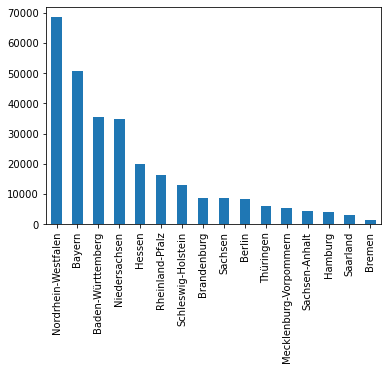

In [15]:
df['bundesland'].value_counts().plot.bar()
df['bundesland'].value_counts()

That all looks sensible, for example NRW is the most populous state in Germany, and here we see it has the largest representation in dataset.

### Feature: total_bonus
This is real valued feature. Given that it is a customer bonus we expect this value to be 0 at a minimum, otherwise positive. Without any other background information it is not possible to say whether the distribution of its values is valid or if the max value observed is correct. We already know that there are no missing values for this feature. 

Now some descriptive statistics will be generated:

In [16]:
df.describe()

,total_bonus
count,318345.000000
mean,150.590275
std,53.692176
min,0.000000
25%,112.000000
50%,149.000000
75%,182.000000
max,570.000000


Looks fine, no issues to be addressed.

### Feature: order_date
We'll treat this ordinal feature like a categorical feature. Let's see what _categories_ are present and whether they look sensible.

See here for some discussion about what type of data a date is: https://stats.stackexchange.com/questions/332688/what-type-of-data-are-dates

In [17]:
df['order_date'].unique()

array(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
       '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
       '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
       '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
       '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
       '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
       '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
       '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
       '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
       '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
       '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
       '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
       '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
       '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
       '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
       '2018-03-02', '2018-03-03', '2018-03-04', '2018-

Looks fine, no further action required. Next step: Cleansing!